# Euclidean Alignment + Weighted TL

## Load dataset

In [1]:
import sys

In [2]:
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\csp')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import moabb.datasets
import moabb.paradigms


from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class, process_s_data
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

In [4]:
dframe = pd.DataFrame

In [5]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [6]:
# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    data_path = '../../datasets/BCICIV2a/A{:02d}T.npz'.format(subj)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['s'] = deepcopy(ori_data[subj]['s'])
    mod_data[subj]['etyp'] = deepcopy(ori_data[subj]['etyp'])
    mod_data[subj]['epos'] = deepcopy(ori_data[subj]['epos'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['s'] = np.delete(mod_data[subj]['s'], np.s_[22:], 1)

## Preprocessing

### Apply Bandpass Filter

In [7]:
from scipy.signal import firwin, freqs, lfilter

In [8]:
# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [9]:
## PREPROCESSING ##

# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

# Key to store result
EEG_filtered = 'EEG_filtered'

for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['s']
    
    mod_data[subj][EEG_filtered] = apply_bandpass(temp_raw_EEG, b)

### Fetch Left and Right Class

In [10]:
mod_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered'])

In [12]:
## Only fetch left and right class
mod_data = fetch_left_right_EEG(mod_data, ori_data=ori_data)
    
# Checking current size of EEG left and right data
print('\t\tLeft \t\t Right')

for subj in mod_data.keys():
    
    temp = mod_data[subj]
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['EEG_left'].shape, temp['EEG_right'].shape)) 

Processing for  1
Processing for  2
Processing for  3
Processing for  4
Processing for  5
Processing for  6
Processing for  7
Processing for  8
Processing for  9
		Left 		 Right
subject01:	(72, 22, 750)	(72, 22, 750)
subject02:	(72, 22, 750)	(72, 22, 750)
subject03:	(72, 22, 750)	(72, 22, 750)
subject04:	(72, 22, 750)	(72, 22, 750)
subject05:	(72, 22, 750)	(72, 22, 750)
subject06:	(72, 22, 750)	(72, 22, 750)
subject07:	(72, 22, 750)	(72, 22, 750)
subject08:	(72, 22, 750)	(72, 22, 750)
subject09:	(72, 22, 750)	(72, 22, 750)


In [13]:
# NEWLY ADDED FUNCTION PRCESS samples x chann of EEG FILTERED -> trials x samples x channel
for subj in mod_data.keys():
    process_s_data(mod_data[subj])
    print(mod_data[subj]['all_trials'].shape)

(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)


In [14]:
mod_data[1]['y']

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0.])

## Apply Data Alignment on raw EEG

In [23]:
# Import necessary library
from scipy.linalg import sqrtm, inv 

def apply_EA(data, key_list):
    '''
    Apply Euclidean aligment on array-like objects for 1 subject
    
    PARAMETER:
    data:
    dictionary data of one subject.
    dictionary containing left and right EEG data of each subject
    
    key_list:
    keys inside dict in which data that is about to be aligned are stored
    
    OUTPUT:
    dictionary data with aligned version of key_list
    '''
    
    # So that this function can handles separated or combined left and right trials
    # If they are separated
    if len(key_list) > 1:
        # Concatenate left and right class
        print('processing separated left and right')
        left_key = [key for key in key_list if 'left' in key]
        right_key = [key for key in key_list if 'right' in key]

        left_trial = data[left_key[0]]
        right_trial = data[right_key[0]]

        # Concate both left and right trial
        all_trials = np.concatenate([left_trial, right_trial], axis=0)
    # If they are not separated
    else:
        print('processing combined left and right')
        all_trials = data[key_list[0]]
    
    # Calculate reference matrix
    RefEA = 0

    # Iterate over all trials, compute reference EA
    for trial in all_trials:
        cov = np.cov(trial, rowvar=True)
        RefEA += cov

    # Average over all trials
    RefEA = RefEA/all_trials.shape[0]

    # Add to data
    data['RefEA'] = RefEA 
    
    # Compute R^(-0.5)
    R_inv = sqrtm(inv(RefEA))
    
    # Again here, they way we stored the key is distinguised
    if len(key_list) > 1:
        # Perform alignment on each trial
        X_EA_left = []
        X_EA_right = []

        for left, right in zip(left_trial, right_trial):
            X_EA_left.append(R_inv@left)
            X_EA_right.append(R_inv@right)

        # Store as left_EA and right_EA
        print('Adding EA_left and EA_right key ')
        data['EEG_left_EA'] = np.array(X_EA_left)
        data['EEG_right_EA'] = np.array(X_EA_right)
    
    # If they are not separated
    else:
        print('storing back into dict')
        all_trials = data[key_list[0]]
            
        # Perform EA on each trial
        all_trials_EA = []
        
        for t in all_trials:
            all_trials_EA.append(R_inv@t)
        
        # Store them back in data dict
        data['all_trials_EA'] = np.array(all_trials_EA)

In [24]:
# Iterate over all subjects to apply EA to all trials
# Define keys to be processed
process_key = ['all_trials']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
processing combined left and right
storing back into dict

Processing subject  2
processing combined left and right
storing back into dict

Processing subject  3
processing combined left and right
storing back into dict

Processing subject  4
processing combined left and right
storing back into dict

Processing subject  5
processing combined left and right
storing back into dict

Processing subject  6
processing combined left and right
storing back into dict

Processing subject  7
processing combined left and right
storing back into dict

Processing subject  8
processing combined left and right
storing back into dict

Processing subject  9
processing combined left and right
storing back into dict



In [24]:
# Iterate over all subjects to compute the aligned EEG trials
# Define keys to be processed
process_key = ['EEG_left', 'EEG_right']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
Adding EA_left and EA_right key 

Processing subject  2
Adding EA_left and EA_right key 

Processing subject  3
Adding EA_left and EA_right key 

Processing subject  4
Adding EA_left and EA_right key 

Processing subject  5
Adding EA_left and EA_right key 

Processing subject  6
Adding EA_left and EA_right key 

Processing subject  7
Adding EA_left and EA_right key 

Processing subject  8
Adding EA_left and EA_right key 

Processing subject  9
Adding EA_left and EA_right key 



In [25]:
dframe(mod_data[3]['RefEA']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,126.578000,113.450491,121.890354,125.048807,122.832999,116.667325,95.330391,105.983847,114.859309,118.086961,...,102.479355,100.124373,105.326346,107.086636,107.135934,103.535207,96.415791,99.552944,96.617988,89.172258
1,113.450491,120.167172,119.290552,118.727037,112.595935,108.453715,101.351636,114.871338,115.990974,116.664564,...,95.240181,108.663319,108.331924,108.773969,105.467198,100.594132,101.308131,102.046814,97.651932,92.584846
2,121.890354,119.290552,127.240373,126.883293,122.933832,114.948635,101.561299,115.340643,123.362333,124.799627,...,102.220240,110.568922,114.963094,115.418358,113.356402,107.844761,105.949791,108.247740,104.031317,97.312976
3,125.048807,118.727037,126.883293,133.766229,127.936946,122.162903,97.912251,114.299349,123.264221,130.365676,...,105.866195,110.221417,114.396936,119.369008,117.196618,111.992782,106.030005,109.851435,106.402586,98.027520
4,122.832999,112.595935,122.933832,127.936946,128.230478,122.696843,95.846873,108.882389,120.054399,125.926298,...,110.912987,106.141781,113.091811,117.042131,117.632538,114.287923,105.480777,109.861169,107.615822,98.753366


In [26]:
left_alg = mod_data[1]['all_trials_EA']

In [27]:
left_alg.shape

(144, 22, 750)

In [28]:
summ = 0
for tr in left_alg:
    summ += np.cov(tr, rowvar=True)
    
I = summ/left_alg.shape[0]
I = pd.DataFrame(np.round(I))

In [29]:
I

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
1,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
4,-0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
5,-0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
6,0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,...,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
9,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Sanity check
for subj in mod_data.keys():
    summ = 0
    
#     left_alg = mod_data[subj]['EEG_left_EA']
#     right_alg = mod_data[subj]['EEG_right_EA']
    left_alg = mod_data[subj]['all_trials_EA']

    for tr in left_alg:
        summ += np.cov(tr, rowvar=True)
    
    I = summ/left_alg.shape[0]
    I = pd.DataFrame(np.round(I))
    
    # Sum up all matrix elements should equal to number of eeg channels, i.e. 22
    assert (I.sum().sum() == 22)
    print('Subject {} OK!'.format(subj))

Subject 1 OK!
Subject 2 OK!
Subject 3 OK!
Subject 4 OK!
Subject 5 OK!
Subject 6 OK!
Subject 7 OK!
Subject 8 OK!
Subject 9 OK!


## Visualize raw data with and without EA

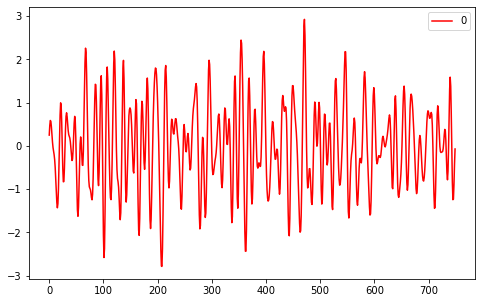

In [23]:
# let's try for one subject
fig, ax = plt.subplots(1, 1,  figsize=(8, 5))
n_alg = pd.DataFrame(mod_data[1]['EEG_left'][10][5])
alg = pd.DataFrame(mod_data[1]['EEG_left_EA'][10][5])

# n_alg.plot(ax=ax, color='k')
alg.plot(ax=ax, color='red')
plt.show()

In [24]:
def visualize_raw_and_aligned(data_dict, no_subj=1, no_trial=0, fs=250):
    '''
    Will plot the visualization of dictionary, left and right hand class
    
    Parameter:
    data_dict = data containing data of each subject
    '''
    left = data_dict[no_subj]['EEG_left'][no_trial]
    right = data_dict[no_subj]['EEG_right'][no_trial]
    left_alg = data_dict[no_subj]['EEG_left_EA'][no_trial]
    right_alg = data_dict[no_subj]['EEG_right_EA'][no_trial]
    
    # Time
    time = np.arange(left.shape[1])/fs
    
    # Number of electrodes
    n_el = left.shape[0]
    
    # Plot each raw EEG and aligned raw EEG
    fig, axes = plt.subplots(n_el, 2, figsize=(10, 15), sharex=True)
    
    # Title to each column
    axes[0, 0].set_title('Left')
    axes[0, 1].set_title('Right')

    # Plot each eeg raw and aligned 
    for i, ax in enumerate(axes):
        ax[0].plot(time, left[i], color='k', label='el ' + str(i))
        ax[0].plot(time, left_alg[i], color='r', label='el ' + str(i))
        ax[0].legend(loc=1)
        
        ax[1].plot(time, right[i], color='k', label='el ' + str(i))
        ax[1].plot(time, right_alg[i], color='r', label='el ' + str(i))
        ax[1].legend(loc=1)
    plt.show()

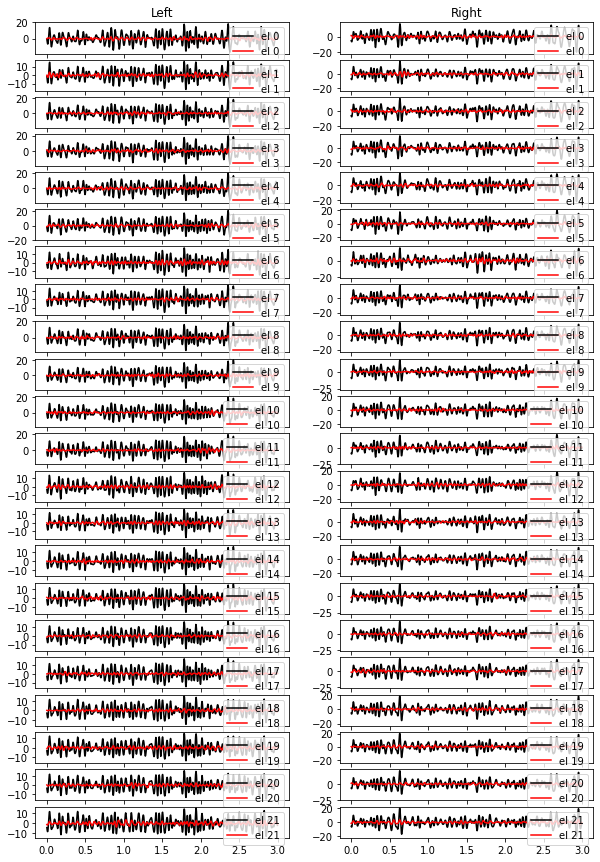

In [26]:
visualize_raw_and_aligned(mod_data, no_subj=2, no_trial=0, fs=250)

## Run CSP for both raw EEG and raw EEG aligned
Should test EEG raw be aligned?

In [27]:
## Split to train and test data
np.random.seed(42)
for subj in mod_data.keys():
    print('Processing split for', subj)
    
    mod_data[subj]['left_train'], mod_data[subj]['left_test'] = split_EEG_one_class(mod_data[subj]['EEG_left'], 0.8)
    mod_data[subj]['right_train'], mod_data[subj]['right_test'] = split_EEG_one_class(mod_data[subj]['EEG_right'], 0.8)     
 
    mod_data[subj]['left_train_EA'], mod_data[subj]['left_test_EA'] = split_EEG_one_class(mod_data[subj]['EEG_left_EA'], 0.8)
    mod_data[subj]['right_train_EA'], mod_data[subj]['right_test_EA'] = split_EEG_one_class(mod_data[subj]['EEG_right_EA'], 0.8)   

Processing split for 1
Processing split for 2
Processing split for 3
Processing split for 4
Processing split for 5
Processing split for 6
Processing split for 7
Processing split for 8
Processing split for 9


In [28]:
# Checking size of EEG left and right data training and test data
print("==================== Not Aligned ======================")
print('\t\tLeft \t\t Right')
print('TRAINING')
for subj in mod_data.keys():
    
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_train'].shape, temp['right_train'].shape))

print('TEST')
for subj in mod_data.keys():

    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_test'].shape, temp['right_test'].shape))

print("\n==================== Aligned ======================")
print('TRAINING')
for subj in mod_data.keys():
    
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_train_EA'].shape, temp['right_train_EA'].shape))

print('TEST')
for subj in mod_data.keys():

    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_test_EA'].shape, temp['right_test_EA'].shape))    


==================== Not Aligned ======================
		Left 		 Right
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22, 750)
subject05:	(58, 22, 750)	(58, 22, 750)
subject06:	(58, 22, 750)	(58, 22, 750)
subject07:	(58, 22, 750)	(58, 22, 750)
subject08:	(58, 22, 750)	(58, 22, 750)
subject09:	(58, 22, 750)	(58, 22, 750)
TEST
subject01:	(14, 22, 750)	(14, 22, 750)
subject02:	(14, 22, 750)	(14, 22, 750)
subject03:	(14, 22, 750)	(14, 22, 750)
subject04:	(14, 22, 750)	(14, 22, 750)
subject05:	(14, 22, 750)	(14, 22, 750)
subject06:	(14, 22, 750)	(14, 22, 750)
subject07:	(14, 22, 750)	(14, 22, 750)
subject08:	(14, 22, 750)	(14, 22, 750)
subject09:	(14, 22, 750)	(14, 22, 750)

==================== Aligned ======================
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22,

## CSP

### For Not Aligned

In [29]:
csp = CSP()

print("====================== Not Aligned Data =====================")
for subj in mod_data.keys():

    print('Computing cov for ', subj)
    print('---------------------------')
    
    mod_data[subj]['CSP'] = {}
    
    # Covariance
    print('Computing covariance of each class and composite covariance')
    mod_data[subj]['CSP']['cov_left'] = csp.compute_cov(mod_data[subj]['left_train'])
    mod_data[subj]['CSP']['cov_right'] = csp.compute_cov(mod_data[subj]['right_train'])
    mod_data[subj]['CSP']['cov_comp']  = mod_data[subj]['CSP']['cov_left'] + mod_data[subj]['CSP']['cov_right']
    
    # Whitening matrix
    print('Computing eigenval, eigenvec, and whitening matrix of composite covariance ')
    mod_data[subj]['CSP']['whitening'] = {}
    
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening = mod_data[subj]['CSP']['whitening']
    temp_cov = mod_data[subj]['CSP']['cov_comp']
    
    temp_whitening['eigval'], temp_whitening['eigvec'] = csp.decompose_cov(temp_cov)

    # White matrix
    temp_whitening['P'] = csp.white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])
    
    # Common eigenvec from Sl and Sr
    print('Generating common eigenvector from each class')
    mod_data[subj]['CSP']['S_left'] = {}
    mod_data[subj]['CSP']['S_right'] = {}  
    
    # Where to access data
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    Cl = mod_data[subj]['CSP']['cov_left']
    Cr = mod_data[subj]['CSP']['cov_right']
    
    # Where to store result
    temp_Sl = mod_data[subj]['CSP']['S_left']
    temp_Sr = mod_data[subj]['CSP']['S_right']

    # LEFT
    Sl = csp.compute_S(Cl, temp_P)
    temp_Sl['eigvec'], temp_Sl['eigval'] = csp.decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = csp.compute_S(Cr, temp_P)
    temp_Sr['eigvec'], temp_Sr['eigval'] = csp.decompose_S(Sr, 'ascending')   
    
    # Spatial filter
    print('Spatial filter for ',subj)
    temp_eigvec = mod_data[subj]['CSP']['S_left']['eigvec']
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    
    mod_data[subj]['CSP']['W'] = csp.spatial_filter(temp_eigvec, temp_P)
    
    print(' ')

====================== Not Aligned Data =====================
Computing cov for  1
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  1
 
Computing cov for  2
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  2
 
Computing cov for  3
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  3
 
Computing cov for  4
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite 

### Aligned Data

In [30]:
csp = CSP()

print("====================== Aligned Data =====================")
for subj in mod_data.keys():

    print('Computing cov for ', subj)
    print('---------------------------')
    
    mod_data[subj]['CSP_EA'] = {}
    
    # Covariance
    print('Computing covariance of each class and composite covariance')
    mod_data[subj]['CSP_EA']['cov_left'] = csp.compute_cov(mod_data[subj]['EEG_left_EA'])
    mod_data[subj]['CSP_EA']['cov_right'] = csp.compute_cov(mod_data[subj]['EEG_right_EA'])
    mod_data[subj]['CSP_EA']['cov_comp']  = mod_data[subj]['CSP_EA']['cov_left'] + mod_data[subj]['CSP_EA']['cov_right']
    
    # Whitening matrix
    print('Computing eigenval, eigenvec, and whitening matrix of composite covariance ')
    mod_data[subj]['CSP_EA']['whitening'] = {}
    
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening = mod_data[subj]['CSP_EA']['whitening']
    temp_cov = mod_data[subj]['CSP_EA']['cov_comp']
    
    temp_whitening['eigval'], temp_whitening['eigvec'] = csp.decompose_cov(temp_cov)

    # White matrix
    temp_whitening['P'] = csp.white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])
    
    # Common eigenvec from Sl and Sr
    print('Generating common eigenvector from each class')
    mod_data[subj]['CSP_EA']['S_left'] = {}
    mod_data[subj]['CSP_EA']['S_right'] = {}  
    
    # Where to access data
    temp_P = mod_data[subj]['CSP_EA']['whitening']['P']
    Cl = mod_data[subj]['CSP_EA']['cov_left']
    Cr = mod_data[subj]['CSP_EA']['cov_right']
    
    # Where to store result
    temp_Sl = mod_data[subj]['CSP_EA']['S_left']
    temp_Sr = mod_data[subj]['CSP_EA']['S_right']

    # LEFT
    Sl = csp.compute_S(Cl, temp_P)
    temp_Sl['eigvec'], temp_Sl['eigval'] = csp.decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = csp.compute_S(Cr, temp_P)
    temp_Sr['eigvec'], temp_Sr['eigval'] = csp.decompose_S(Sr, 'ascending')   
    
    # Spatial filter
    print('Spatial filter for ',subj)
    temp_eigvec = mod_data[subj]['CSP_EA']['S_left']['eigvec']
    temp_P = mod_data[subj]['CSP_EA']['whitening']['P']
    
    mod_data[subj]['CSP_EA']['W'] = csp.spatial_filter(temp_eigvec, temp_P)
    
    print(' ')

====================== Aligned Data =====================
Computing cov for  1
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  1
 
Computing cov for  2
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  2
 
Computing cov for  3
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  3
 
Computing cov for  4
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite cova

## Train Feature

### Not Aligned Data

In [31]:
# Select number of filter
m = 2

# Seed to fix randomization
np.random.seed(42)

print('============ Not Aligned ===============')
# Create new keys for trainning and test feature vector
for subj in mod_data.keys():
    
    print('Generating training vector for ', subj)
    
    mod_data[subj]['train']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['left_train']
    temp_EEG_right = mod_data[subj]['right_train']
    
    # LEFT
    mod_data[subj]['train']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['train']['feat_left'] = feat_vector(mod_data[subj]['train']['Z_left'])
    left_label = true_label(mod_data[subj]['train']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['train']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['train']['feat_right'] = feat_vector(mod_data[subj]['train']['Z_right'])     
    right_label = true_label(mod_data[subj]['train']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['train']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['train']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['train']['feat_train'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['train']['feat_train'])
    
    print('Training dataset shape {}\n'.format(mod_data[subj]['train']['feat_train'].shape))

============ Not Aligned ===============
Generating training vector for  1
Training dataset shape (116, 5)

Generating training vector for  2
Training dataset shape (116, 5)

Generating training vector for  3
Training dataset shape (116, 5)

Generating training vector for  4
Training dataset shape (116, 5)

Generating training vector for  5
Training dataset shape (116, 5)

Generating training vector for  6
Training dataset shape (116, 5)

Generating training vector for  7
Training dataset shape (116, 5)

Generating training vector for  8
Training dataset shape (116, 5)

Generating training vector for  9
Training dataset shape (116, 5)



In [32]:
mod_data[1]['train']['feat_train'][:5]

array([[-0.80850967, -0.6600156 , -0.48623359, -0.52374037,  1.        ],
       [-0.40809937, -0.50156184, -0.85628869, -0.80985649,  0.        ],
       [-0.45061195, -0.53515375, -0.78251033, -0.72343572,  0.        ],
       [-0.62933009, -0.5755371 , -0.46896779, -0.79636582,  0.        ],
       [-0.7143548 , -0.53946605, -0.52948956, -0.65221154,  0.        ]])

### Aligned Data

In [33]:
# Select number of filter
m = 2

# Seed to fix randomization
np.random.seed(42)

print('============ Aligned ===============')
# Create new keys for trainning and test feature vector
for subj in mod_data.keys():
    
    print('Generating training vector for ', subj)
    
    mod_data[subj]['train_EA']= {}  

    temp_W = mod_data[subj]['CSP_EA']['W']
    temp_EEG_left = mod_data[subj]['left_train_EA']
    temp_EEG_right = mod_data[subj]['right_train_EA']
    
    # LEFT
    mod_data[subj]['train_EA']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['train_EA']['feat_left'] = feat_vector(mod_data[subj]['train_EA']['Z_left'])
    left_label = true_label(mod_data[subj]['train_EA']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['train_EA']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['train_EA']['feat_right'] = feat_vector(mod_data[subj]['train_EA']['Z_right'])     
    right_label = true_label(mod_data[subj]['train_EA']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['train_EA']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['train_EA']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['train_EA']['feat_train'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['train_EA']['feat_train'])
    
    print('Training dataset shape {}\n'.format(mod_data[subj]['train_EA']['feat_train'].shape))

============ Aligned ===============
Generating training vector for  1
Training dataset shape (116, 5)

Generating training vector for  2
Training dataset shape (116, 5)

Generating training vector for  3
Training dataset shape (116, 5)

Generating training vector for  4
Training dataset shape (116, 5)

Generating training vector for  5
Training dataset shape (116, 5)

Generating training vector for  6
Training dataset shape (116, 5)

Generating training vector for  7
Training dataset shape (116, 5)

Generating training vector for  8
Training dataset shape (116, 5)

Generating training vector for  9
Training dataset shape (116, 5)



## Test Feature

### For Not Aligned

In [34]:
# Create new keys for test feature vector
np.random.seed(42)

for subj in mod_data.keys():
    
    print('Generating test vector for ', subj)
    
    mod_data[subj]['test']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['left_test']
    temp_EEG_right = mod_data[subj]['right_test']
      
    # LEFT
    mod_data[subj]['test']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['test']['feat_left'] = feat_vector(mod_data[subj]['test']['Z_left'])
    left_label = true_label(mod_data[subj]['test']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['test']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['test']['feat_right'] = feat_vector(mod_data[subj]['test']['Z_right'])     
    right_label = true_label(mod_data[subj]['test']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['test']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['test']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['test']['feat_test'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['test']['feat_test'])
    
    print('Test dataset shape {}\n'.format(mod_data[subj]['test']['feat_test'].shape))

Generating test vector for  1
Test dataset shape (28, 5)

Generating test vector for  2
Test dataset shape (28, 5)

Generating test vector for  3
Test dataset shape (28, 5)

Generating test vector for  4
Test dataset shape (28, 5)

Generating test vector for  5
Test dataset shape (28, 5)

Generating test vector for  6
Test dataset shape (28, 5)

Generating test vector for  7
Test dataset shape (28, 5)

Generating test vector for  8
Test dataset shape (28, 5)

Generating test vector for  9
Test dataset shape (28, 5)



In [35]:
mod_data[1]['test']['feat_test'][:5]

array([[-0.54764994, -0.52291841, -0.59991892, -0.78140058,  0.        ],
       [-0.78563928, -0.50154629, -0.4974035 , -0.69260143,  1.        ],
       [-0.50800975, -0.44099642, -0.73292701, -0.84665142,  0.        ],
       [-0.69895462, -0.65752097, -0.50560207, -0.57220645,  1.        ],
       [-0.42377025, -0.5038312 , -0.81735151, -0.80309321,  0.        ]])

### For Aligned

In [36]:
# Create new keys for test feature vector
np.random.seed(42)

for subj in mod_data.keys():
    
    print('Generating test vector for ', subj)
    
    mod_data[subj]['test_EA']= {}  

    temp_W = mod_data[subj]['CSP_EA']['W']
    temp_EEG_left = mod_data[subj]['left_test_EA']
    temp_EEG_right = mod_data[subj]['right_test_EA']
      
    # LEFT
    mod_data[subj]['test_EA']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['test_EA']['feat_left'] = feat_vector(mod_data[subj]['test_EA']['Z_left'])
    left_label = true_label(mod_data[subj]['test_EA']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['test_EA']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['test_EA']['feat_right'] = feat_vector(mod_data[subj]['test_EA']['Z_right'])     
    right_label = true_label(mod_data[subj]['test_EA']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['test_EA']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['test_EA']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['test_EA']['feat_test'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['test_EA']['feat_test'])
    
    print('Test dataset shape {}\n'.format(mod_data[subj]['test_EA']['feat_test'].shape))

Generating test vector for  1
Test dataset shape (28, 5)

Generating test vector for  2
Test dataset shape (28, 5)

Generating test vector for  3
Test dataset shape (28, 5)

Generating test vector for  4
Test dataset shape (28, 5)

Generating test vector for  5
Test dataset shape (28, 5)

Generating test vector for  6
Test dataset shape (28, 5)

Generating test vector for  7
Test dataset shape (28, 5)

Generating test vector for  8
Test dataset shape (28, 5)

Generating test vector for  9
Test dataset shape (28, 5)



In [63]:
mod_data[1]['EEG_left'].shape

(72, 22, 750)

## CSP algorithm ver 2 (MATLAB)
This CSP algorithm is adopted from the TLBCI MATLAB code. Used this code to process EEG data and output feature,   
ver2 computes each left and right separately,  
ver3 computes all trials at once

In [67]:
import numpy.linalg as la

def csp_feat_ver2(data, no_subj=1, n_filter=3):
    '''
    Adaptation of MATLAB csp code in python, the original work is called TLBCI 
    
    Parameter:
    data: dictionary containing data of each subject EEG signal, y class
    '''
    
    n_chan = data[no_subj]['EEG_left'].shape[1]
    
    EEG_left = data[no_subj]['EEG_left']
    EEG_right = data[no_subj]['EEG_right']
    
    # Covariance of left and right
    cov_left = 0
    for signal in range(EEG_left.shape[0]):
        cov_left += np.cov(signal, rowvar=True, ddof=0)
    
    cov_left = cov_left/EEG_left.shape[0]
    
    cov_right = 0
    for signal in range(EEG_right.shape[0]):
        cov_right += np.cov(signal, rowvar=True, ddof=0)

    cov_left = cov_right/EEG_right.shape[0]

    mldiv = la.lstsq(cov_right, cov_left)
    
    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)
    
    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]
    
    # W matrix
    W = np.delete(eigvec, np.s_[n_filter:-n_filter], axis=1)
    
    # Calculating feature train 
    feat_left = []
    for trial in EEG_left:
        X = W.T@trial
        feat_left.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)))
    
    feat_right = []
    for trial in EEG_right:
        X = W.T@trial
        feat_right.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)))
        
    feat_left = np.array(feat_left)
    feat_right = np.array(feat_right)

In [35]:
import numpy.linalg as la

def csp_feat_ver3(data, n_filter=3, key='all_trials'):
    '''
    Adaptation of MATLAB csp code in python, the original work is called TLBCI 
    
    Parameter:
    data: dictionary containing data of each subject EEG signal, y class
    '''

    ids_left = np.argwhere(y == 0).ravel()
    ids_right = np.argwhere(y == 1).ravel()

    EEG_all = data[key]
    EEG_left = EEG_all[ids_left]
    EEG_right = EEG_all[ids_right]

    # Covariance of left and right
    cov_left = 0
    for signal in EEG_left:
        cov_left += np.cov(signal, rowvar=True, ddof=1)

    cov_left = cov_left/EEG_left.shape[0]

    cov_right = 0
    for signal in EEG_right:
        cov_right += np.cov(signal, rowvar=True, ddof=1)

    cov_right = cov_right/EEG_right.shape[0]

    mldiv = la.lstsq(cov_right, cov_left, rcond=None)[0]

    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)

    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]

    # W matrix
    W = np.delete(eigvec, np.s_[n_filter:-n_filter], axis=1)

    # Calculating feature train 
    all_feat = []
    for trial in EEG_all:
        X = W.T@trial
        all_feat.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 

    return np.array(all_feat)

In [40]:
# Iterate over all subject, process CSP for non-EA trials
for subj in mod_data.keys():
    mod_data[subj]['all_feats'] = csp_feat_ver3(mod_data[subj], key='all_trials')
    mod_data[subj]['all_feats_EA'] = csp_feat_ver3(mod_data[subj], key='all_trials_EA')

### T-SNE for feature generated using csp_feat_ver3

In [45]:
from sklearn.manifold import TSNE

list_subj = []

# Perform sne on all subject
for subj in mod_data.keys():
    print('Processing {:02d}'.format(subj))
    mod_data[subj]['sne'] = TSNE(n_iter=2000).fit_transform(mod_data[subj]['all_feats'])
    mod_data[subj]['sne_EA'] = TSNE(n_iter=2000).fit_transform(mod_data[subj]['all_feats_EA'])
    list_subj.append(subj)

Processing 01
Processing 02
Processing 03
Processing 04
Processing 05
Processing 06
Processing 07
Processing 08
Processing 09


In [50]:
import seaborn as sns
palette = np.array(sns.color_palette(n_colors=11))

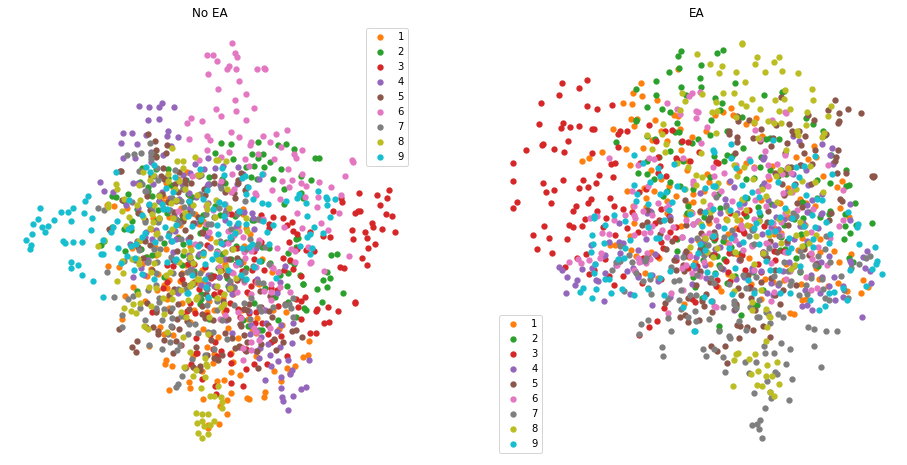

In [54]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for subj in mod_data.keys():
    ax0.set_title('No EA')
    ax0.scatter(mod_data[subj]['sne'][:, 0], mod_data[subj]['sne'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('EA')
    ax1.scatter(mod_data[subj]['sne_EA'][:, 0], mod_data[subj]['sne_EA'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

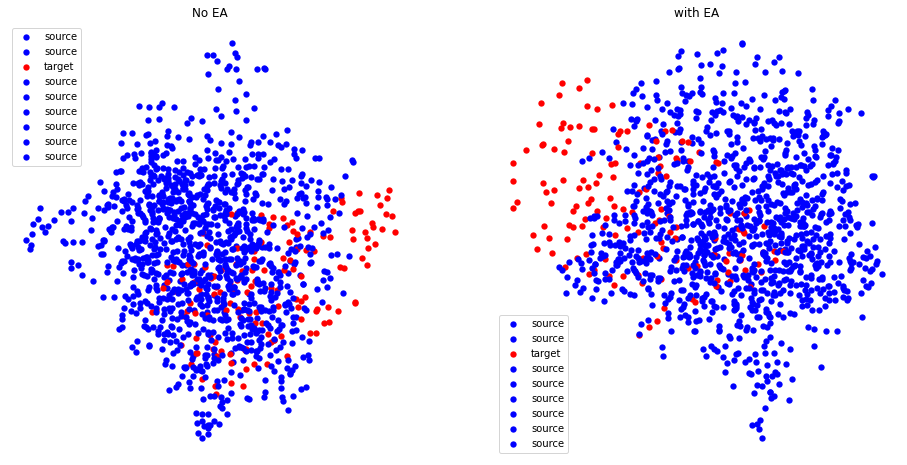

In [64]:
# target vs subject
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for subj in mod_data.keys():
    ax0.set_title('No EA')
    tgt_subj = 3
    if subj == tgt_subj:
        ax0.scatter(mod_data[subj]['sne'][:, 0], mod_data[subj]['sne'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(mod_data[subj]['sne'][:, 0], mod_data[subj]['sne'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if subj == tgt_subj:
        ax1.scatter(mod_data[subj]['sne_EA'][:, 0], mod_data[subj]['sne_EA'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(mod_data[subj]['sne_EA'][:, 0], mod_data[subj]['sne_EA'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

### Is CSP feat from aligned raw equal to Identity?

In [68]:
# Pick one feature from any subject
all_feats = mod_data[1]['all_feats']

# all_feats.shape
summ=0

cov = np.cov(all_feats, rowvar=False)
dframe(np.round(cov, 3))
# for tr in all_feats:
#     tr = tr[:, None]
#     summ += np.cov(tr, rowvar=True)
    
# I = summ/all_feats.shape[0]
#     I = pd.DataFrame(np.round(I, 2))
    
# I

,0,1,2,3,4,5
0,0.026,0.013,0.010,0.004,0.003,-0.017
1,0.013,0.025,0.010,0.004,0.001,-0.015
2,0.010,0.010,0.023,0.011,0.009,-0.017
3,0.004,0.004,0.011,0.033,0.026,-0.005
4,0.003,0.001,0.009,0.026,0.031,-0.004
5,-0.017,-0.015,-0.017,-0.005,-0.004,0.028


In [69]:
# Pick one feature from any subject
all_feats = mod_data[1]['all_feats_EA']

# all_feats.shape
summ=0

cov = np.cov(all_feats, rowvar=False)
dframe(np.round(cov, 3))

,0,1,2,3,4,5
0,0.027,0.013,0.013,0.005,0.005,-0.018
1,0.013,0.025,0.013,0.004,0.002,-0.016
2,0.013,0.013,0.029,0.014,0.013,-0.015
3,0.005,0.004,0.014,0.033,0.027,-0.006
4,0.005,0.002,0.013,0.027,0.033,-0.004
5,-0.018,-0.016,-0.015,-0.006,-0.004,0.026


In [70]:
print('EA')
print(mod_data[3]['all_feats'][:5])
print('\nWithout EA')
print(mod_data[3]['all_feats_EA'][:5])

EA
[[-1.03560065 -1.11704216 -1.16108464 -0.65272159 -0.6157135  -0.52615197]
 [-0.66154036 -0.80387366 -1.01440885 -0.74608547 -0.77896027 -0.73901029]
 [-0.41825325 -0.70885585 -0.8591654  -0.98130002 -1.02356492 -1.06875997]
 [-0.69792607 -0.7830371  -1.08507864 -0.70745745 -0.89136713 -0.64214566]
 [-0.71968715 -0.53565599 -1.079541   -0.93054498 -0.94088745 -0.69287526]]

Without EA
[[-1.10918851 -1.13869976 -0.98931571 -0.712019   -0.58040082 -0.53728107]
 [-0.73159067 -0.82199371 -0.83910237 -0.80184532 -0.74011005 -0.74660184]
 [-0.48775267 -0.726425   -0.68330802 -1.03650898 -0.9841638  -1.07580062]
 [-0.76304931 -0.79623009 -0.9048451  -0.75829024 -0.84758984 -0.64481014]
 [-0.787197   -0.55123558 -0.90169407 -0.98376437 -0.89949677 -0.69792635]]


### Comparing feature distribution of not-aligned vs aligned raw EEG

In [39]:
from sklearn.manifold import TSNE

In [40]:
X_EA = np.array([])
X = np.array([])

list_subj = []

for subj in mod_data.keys():
    print('Processing subject: ', subj)
    feat_EA = mod_data[subj]['train_EA']['feat_train'][:, :-1]
    feat = mod_data[subj]['train']['feat_train'][:, :-1]

    if (len(X) == 0) or (len(X_EA) == 0):
        X = feat
        X_EA = feat_EA
    else:
        X = np.vstack([X, feat])
        X_EA = np.vstack([X_EA, feat])
        
    list_subj.append([subj]*len(feat))
    
list_subj = np.array(list_subj).ravel()
X_sne = TSNE(n_iter=1000).fit_transform(X)
X_sne_EA = TSNE(n_iter=1000).fit_transform(X_EA)

Processing subject:  1
Processing subject:  2
Processing subject:  3
Processing subject:  4
Processing subject:  5
Processing subject:  6
Processing subject:  7
Processing subject:  8
Processing subject:  9


In [41]:
print(X_sne.shape)
print(X_sne_EA.shape)

(1044, 2)
(1044, 2)


In [42]:
# Define palette
import seaborn as sns

In [43]:
palette = np.array(sns.color_palette(palette='bright', n_colors=10))

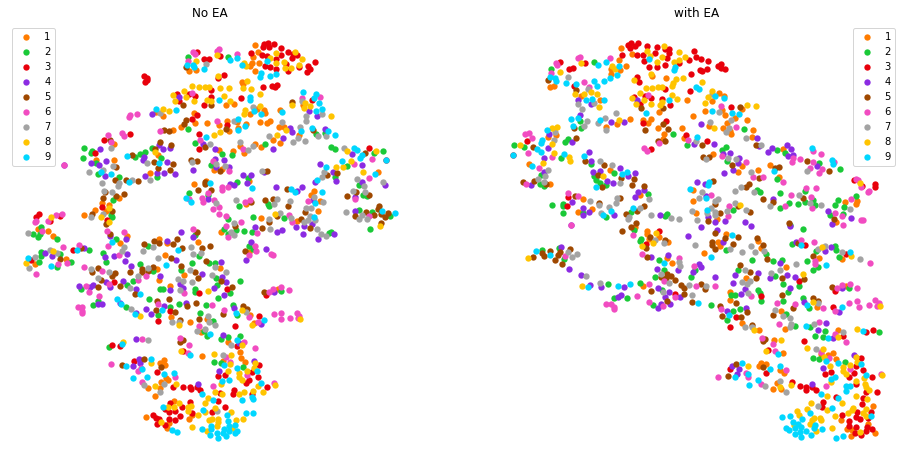

In [122]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

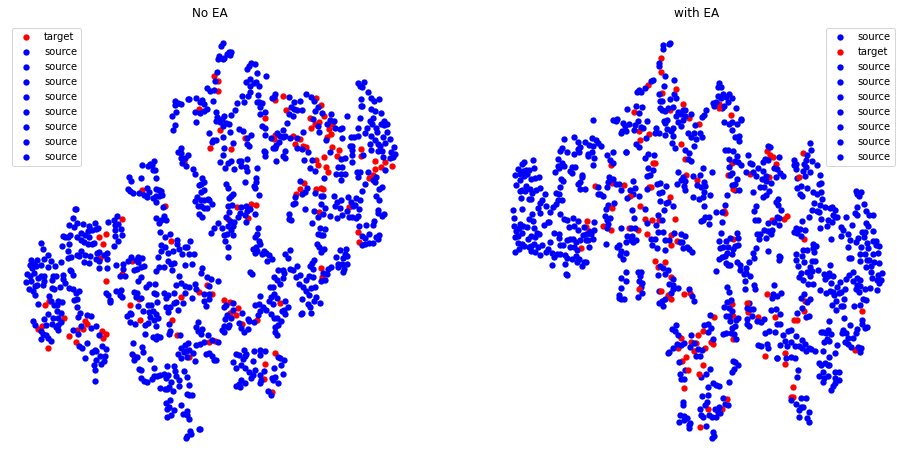

In [265]:
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    if i == 1:
        ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if i == 2:
        ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

### See if all raw_EEG_EA covariance add up to identity matrix

In [162]:
# FOR SEPARATED LEFT AND RIGHT
# Stack all trials of left and right of all subjects
all_trials = np.array([])
all_trials_EA = np.array([])

for subj in mod_data.keys():
    # left and right of each subject
    left = mod_data[subj]['EEG_left']
    right = mod_data[subj]['EEG_right']
    
    left_EA = mod_data[subj]['EEG_left_EA']
    right_EA = mod_data[subj]['EEG_right_EA']
    
    # Stack them together
    both = np.concatenate([left, right], axis=0)
    both_EA = np.concatenate([left_EA, right_EA], axis=0)
    
    # Add to all_trials
    if ((len(all_trials)) or (len(all_trials_EA))) == 0:
        print('creating stack...')
        all_trials = both
        all_trials_EA = both_EA
    else:
        print('adding stack...')
        all_trials = np.concatenate([all_trials, both], axis=0)
        all_trials_EA = np.concatenate([all_trials_EA, both_EA], axis=0)

        
print('In total all trials non-EA in shape of: ', all_trials.shape)
print('In total all trials EA in shape of: ', all_trials_EA.shape)

creating stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
In total all trials non-EA in shape of:  (1296, 22, 750)
In total all trials EA in shape of:  (1296, 22, 750)


In [164]:
# Covariance of all trial
summ == 0
count = 0 
for t in all_trials_EA:
    count += 1
    cov = np.cov(t, rowvar=True, ddof=0)
    summ += cov
    
print(count)
summ = summ/all_trials_EA.shape[0]
dframe(np.round(summ))

1296


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# FOR NON-SEPARATED LEFT AND RIGHT
# Stack all trials of left and right of all subjects
all_trials = np.array([])
all_trials_EA = np.array([])

for subj in mod_data.keys():
    print('Subject {}'.format(subj))
    # left and right of each subject
    both = mod_data[subj]['all_trials']
    both_EA = mod_data[subj]['all_trials_EA']
    
    # Add to all_trials
    if ((len(all_trials)) or (len(all_trials_EA))) == 0:
        print('creating stack...')
        all_trials = both
        all_trials_EA = both_EA
    else:
        print('adding stack...')
        all_trials = np.concatenate([all_trials, both], axis=0)
        all_trials_EA = np.concatenate([all_trials_EA, both_EA], axis=0)

        
print('In total all trials non-EA in shape of: ', all_trials.shape)
print('In total all trials EA in shape of: ', all_trials_EA.shape)

Subject 1
creating stack...
Subject 2
adding stack...
Subject 3
adding stack...
Subject 4
adding stack...
Subject 5
adding stack...
Subject 6
adding stack...
Subject 7
adding stack...
Subject 8
adding stack...
Subject 9
adding stack...
In total all trials non-EA in shape of:  (1296, 22, 750)
In total all trials EA in shape of:  (1296, 22, 750)


In [76]:
# Covariance of all trial
summ == 0
count = 0 
for t in all_trials_EA:
    count += 1
    cov = np.cov(t, rowvar=True, ddof=0)
    summ += cov
    
print(count)
summ = summ/all_trials_EA.shape[0]
# dframe(np.round(summ))
summ.sum().sum()

1296


22.013516346073352

# EA + Weighted TL

## Define target and source subjects

In [115]:
# Create CSP feat algorithm that can split into train and test set 
from sklearn.model_selection import train_test_split

def csp_feat_ver4(data, n_filter=3, train_size=50, key='all_trials'):
    X = data[key]
    y = data['y']

    # Split them into train and test set
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, train_size=train_size, shuffle=True, random_state=42)

    EEG_left = X_tr[y_tr==0]
    EEG_right = X_tr[y_tr==1]

    # Covariance of left and right
    cov_left = 0
    for signal in EEG_left:
        cov_left += np.cov(signal, rowvar=True, ddof=1)

    cov_left = cov_left/EEG_left.shape[0]

    cov_right = 0
    for signal in EEG_right:
        cov_right += np.cov(signal, rowvar=True, ddof=1)

    cov_right = cov_right/EEG_right.shape[0]

    # Matrix left division (adopted from MATLAB)
    mldiv = la.lstsq(cov_right, cov_left, rcond=None)[0]

    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)

    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]

    # W matrix
    W = np.delete(eigvec, np.s_[n_filter:-n_filter], axis=1)

    # Calculating feature train and test
    feat_train = []
    feat_test = []

    for trial_train in X_tr:
        X = W.T@trial_train
        feat_train.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 

    for trial_test in X_te:
        X = W.T@trial_test
        feat_test.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 
        
    return np.array(feat_train), np.array(feat_test), X_tr, X_te, y_tr, y_te

In [127]:
# Define data necessary for target and source subject
TL_data = {}
TL_data['tgt'] = {}
TL_data['src'] = {}

# As target data with only 10 trials, 5 each class
for subj in mod_data.keys():
    TL_data['tgt'][subj] = {}
    TL_data['src'][subj] = {}
    print('Creating target and source data for subject {}'.format(subj))
    # TARGET
    # Here all trials is split into 
    target = TL_data['tgt'][subj]
    
    # Split all trials of a subject into training and test set
    target['feat_train'], target['feat_test'], target['XtrRaw'], target['XteRaw'], target['ytr'], target['yte'] = csp_feat_ver4(mod_data[subj],
                                                                                                                                n_filter=3,
                                                                                                                                train_size=50,
                                                                                                                                key='all_trials')
    
    # SOURCE
    source = TL_data['src'][subj]
    
    # This will store whole trials as if that subject acts as a source
    source['feat_train'] = csp_feat_ver3(mod_data[subj], n_filter=3, key='all_trials')
    source['y'] = deepcopy(mod_data[subj]['y'])
    

Creating target and source data for subject 1
Creating target and source data for subject 2
Creating target and source data for subject 3
Creating target and source data for subject 4
Creating target and source data for subject 5
Creating target and source data for subject 6
Creating target and source data for subject 7
Creating target and source data for subject 8
Creating target and source data for subject 9
